In [23]:
# import libraries -- copied from assignment 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# read in data and print head 

manhattan = pd.read_csv('../data/manhattan.csv')
manhattan.head()

,rental_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,borough
0,1545,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,Upper East Side,Manhattan
1,2472,11500,2.0,2,2000,4,1.0,96,0,0,0,0,0,0,0,0,Greenwich Village,Manhattan
2,2919,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,Manhattan
3,2790,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,Manhattan
4,3946,17500,2.0,2,4800,3,4.0,136,0,0,0,1,1,1,0,1,Soho,Manhattan


In [6]:
# check length of data and number of features (excluding target)

shape = manhattan.shape

print('There are,', shape[0], 'data rows and ', shape[1] -1 , 'features in the dataset')

There are, 3539 data rows and  17 features in the dataset


## __Initial Data Exploration:__

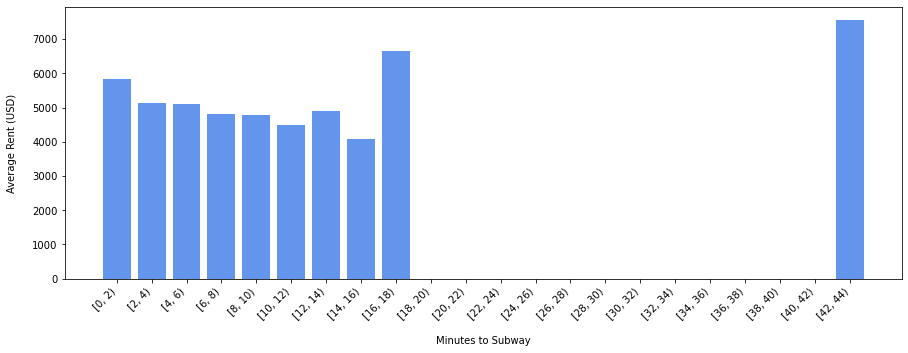

In [ ]:
# First, look at subway time and average rent, binning subway time into 2 minute intervals

# Bin 'min_to_subway' into 5-minute intervals
dt = 2 # binning interval
subway_bins = np.arange(0, manhattan['min_to_subway'].max() + dt, dt) 
manhattan['subway_bin'] = pd.cut(manhattan['min_to_subway'], bins=subway_bins, right=False)

# Calculate mean rent for each subway time bin
avg_rent = manhattan.groupby(['subway_bin'])['rent'].mean().reset_index()

# Set labels for subway time bins
labels = [f"{row.subway_bin}" for row in avg_rent.itertuples(index=False)]

# Create the plot
plt.figure(figsize=(15, 5))
plt.bar(avg_rent.index, avg_rent['rent'], color="cornflowerblue")  # Use default index
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Minutes to Subway", labelpad=15)
plt.ylabel("Average Rent (USD)", labelpad=15)
plt.xticks(ticks=avg_rent.index, labels=labels, rotation=45, ha='right')

plt.show()

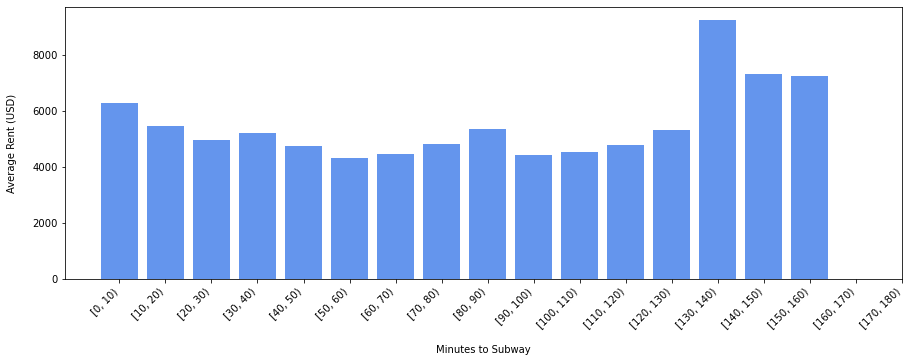

In [17]:
# Second, look at building age and average rent, binning age into 10 year intervals

# Bin 'building_age_yrs' into 10-year intervals
dt = 10  # binning interval
age_bins = np.arange(0, manhattan['building_age_yrs'].max() + dt, dt)
manhattan['age_bins'] = pd.cut(manhattan['building_age_yrs'], bins=age_bins, right=False)

# Calculate mean rent for each subway time bin
avg_rent = manhattan.groupby(['age_bins'])['rent'].mean().reset_index()

# Set labels for subway time bins
labels = [f"{row.age_bins}" for row in avg_rent.itertuples(index=False)]

# Create the plot
plt.figure(figsize=(15, 5))
plt.bar(avg_rent.index, avg_rent['rent'], color="cornflowerblue")  # Use default index
plt.axhline(0, color="black", linewidth=1)

plt.xlabel("Minutes to Subway", labelpad=15)
plt.ylabel("Average Rent (USD)", labelpad=15)
plt.xticks(ticks=avg_rent.index, labels=labels, rotation=45, ha='right')

plt.show()

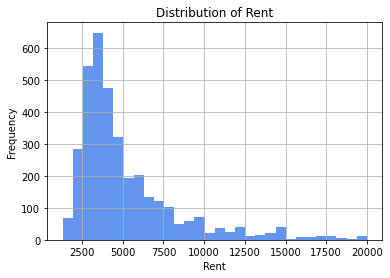

In [21]:
# Check balance of target variable

manhattan['rent'].hist(bins=30, color='cornflowerblue')
plt.xlabel('Rent')
plt.ylabel('Frequency')
plt.title('Distribution of Rent')
plt.show()

## __Clean Data:__

In [30]:
# Set target and drop the rental_id feature, since it is not needed for the model 
# Also drop the borough feature, since it is only Manhattan

manhattan = pd.read_csv('../data/manhattan.csv')

X = manhattan.drop(['rent', 'rental_id', 'borough'], axis=1)
y = manhattan['rent']

In [31]:
# Separate data into development and test sets
# Non-stratified split, 80 percent development, 20 percent test 

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80-20 split

In [37]:
# Encode categorical features -- just neighborhood  

# List categorical (both hot encoding and label encoding) and numerical features 
cat_features_hot = ["neighborhood"]

# encode using One Hot Encoder, since there is no ordering or ranking of neighborhoods
preprocess = make_column_transformer((OneHotEncoder(handle_unknown="error"), cat_features_hot),remainder="passthrough")

transformed_data = preprocess.fit_transform(X_dev)
feature_names = preprocess.get_feature_names_out()

# Convert back to pandas data frame
X_dev = pd.DataFrame(transformed_data, columns=feature_names)

# Encode the test datsets and transform to pandas data frame
X_test = pd.DataFrame(preprocess.transform(X_test), columns=feature_names)


In [38]:
# print to make sure worked correctly

X_dev_encoded.head()

,onehotencoder__neighborhood_Battery Park City,onehotencoder__neighborhood_Central Harlem,onehotencoder__neighborhood_Central Park South,onehotencoder__neighborhood_Chelsea,onehotencoder__neighborhood_Chinatown,onehotencoder__neighborhood_East Harlem,onehotencoder__neighborhood_East Village,onehotencoder__neighborhood_Financial District,onehotencoder__neighborhood_Flatiron,onehotencoder__neighborhood_Gramercy Park,...,remainder__floor,remainder__building_age_yrs,remainder__no_fee,remainder__has_roofdeck,remainder__has_washer_dryer,remainder__has_doorman,remainder__has_elevator,remainder__has_dishwasher,remainder__has_patio,remainder__has_gym
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,10.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,57.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# fit a standard scaler to the training data, apply this standard scaler to the validation/test data  

ss = StandardScaler()

X_dev_scaled = pd.DataFrame(ss.fit_transform(X_dev), columns=feature_names)
X_test_scaled = pd.DataFrame(ss.transform(X_test), columns=feature_names)

# Note, we also put back into pandas data frame -- will ensure we keep feature names when we print out feature importance later 

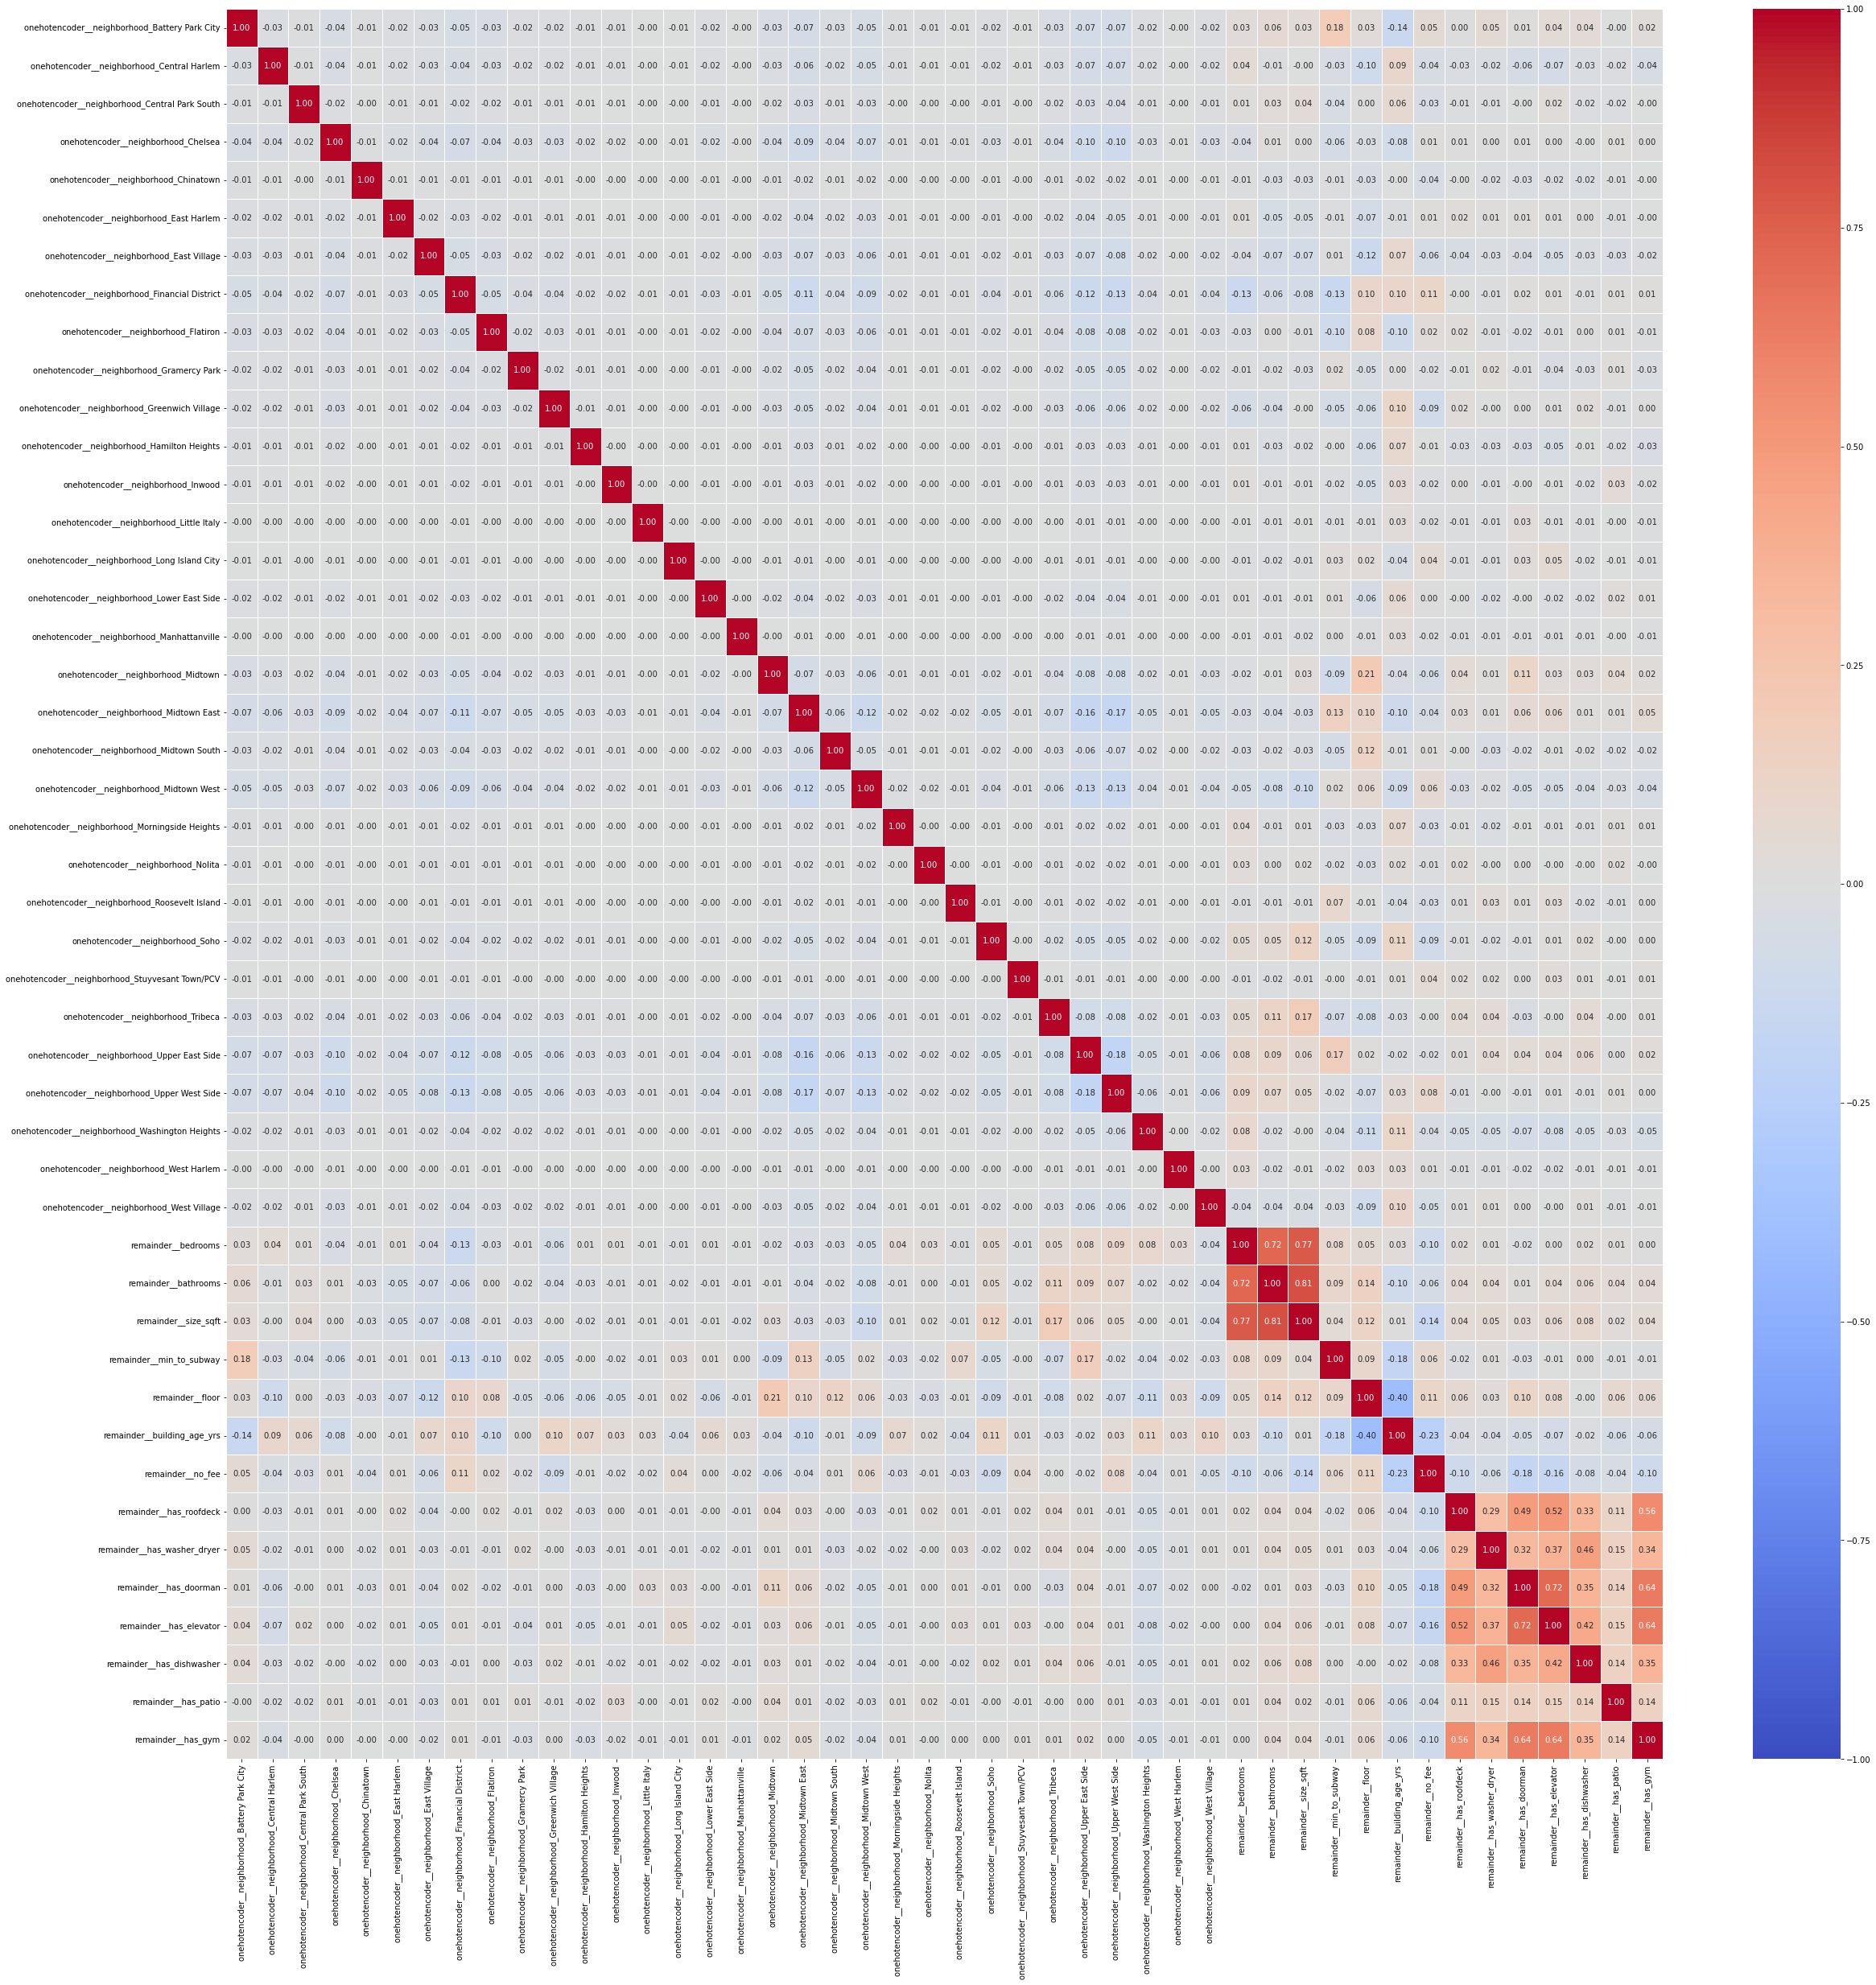

In [42]:
# Compute correlation matrix for development data 

corr_matrix = X_dev.corr()

# Plot correlation matrix
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
plt.show()

There are 0.70-0.80 correlations between square footage, number of bedrooms, and number of bathrooms. This makes sense, since a larger apartment will be able to accomodate more rooms, whether bedrooms or bathrooms. We will keep these in the dataset, since this may only affect a linear model, not decsions trees or other methods we propose using.